In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import dowhy
import matplotlib as plt

from dowhy import gcm
from dowhy import CausalModel

In [2]:
data_path = '../../data/payments_phoenix_2022_processed.csv'
df = pd.read_csv(data_path)

In [3]:
columns = df.columns
df_causal = df[columns[2:]].copy()
df_causal.head()
causal_columns = ['Department','Job Title', 'Full/Part Time', 'Hourly Rate', 'antiguity_months']
df_causal = df_causal[causal_columns]
df_causal.head()
cat_columns = ['Department','Job Title', 'Full/Part Time']
df_causal[cat_columns] = df_causal[cat_columns].astype('category')
df_causal.loc[df_causal['Full/Part Time'] == "F", "FullPartTime"] = 1.0
df_causal.loc[df_causal['Full/Part Time'] == "P", "FullPartTime"] = 0.0
df_causal[0:10]

,Department,Job Title,Full/Part Time,Hourly Rate,antiguity_months,FullPartTime
0,Police Department,Police Officer,F,37.79,365.609150,1.0
1,Police Department,Police Officer,F,30.04,36.501776,1.0
2,Fire Department,Firefighter 56hr,F,24.48,167.592764,1.0
3,Police Department,Forensic Scientist IV,F,51.02,144.134376,1.0
4,Parks & Recreation: Aquatics,Parks & Recreation Aide*Cash,P,12.92,140.454629,0.0
5,Human Services Department,Secretary II,F,15.98,24.082630,1.0
6,Street Transportation Dept,Environmental Quality Spec,F,41.78,63.639910,1.0
7,Planning & Development Dept,Chief Engineering Tech*U7,F,23.58,63.179942,1.0
8,Public Transit,Municipal Security Guard,F,22.64,38.801618,1.0
9,Water Services Department,GIS Coordinator,F,43.92,272.465554,1.0


In [4]:
df_causal = df_causal.dropna()

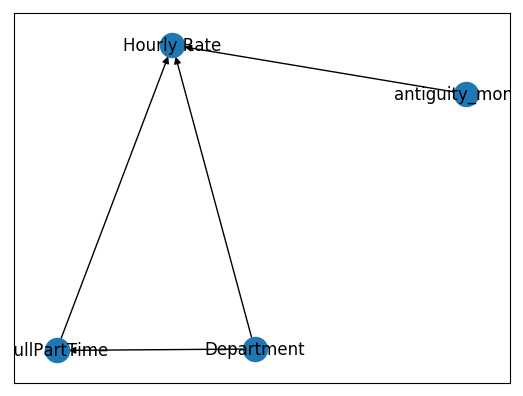

In [6]:
causal_graph = nx.DiGraph()
causal_graph.add_edges_from([('FullPartTime', 'Hourly Rate'),
                             ('antiguity_months', 'Hourly Rate'),
                             ('Department', 'Hourly Rate'),
                             ('Department','FullPartTime')])
nx.draw_networkx(causal_graph, with_labels = True, arrows = True)

Probably, to say that Department is affecting FullPartTime is not completely truth, since should be some policies around the department regarding F/P time employees, the reality is that a lot of U's variables should affect the F/P Time decission as well.

In [7]:
causal_model = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model, df_causal)

In [8]:
gcm.fit(causal_model, df_causal)

Fitting causal mechanism of node Department: 100%|████████████████████████████████████████| 4/4 [00:05<00:00,  1.33s/it]


In [9]:
strength = gcm.arrow_strength(causal_model, 'Hourly Rate')
strength

{('Department', 'Hourly Rate'): 21.418995018859803,
 ('FullPartTime', 'Hourly Rate'): 8.050117900097524,
 ('antiguity_months', 'Hourly Rate'): 24.53041736839038}

By computing counterfactuals, we answer the question:

I observed a certain outcome z for a variable Z where variable X was set to a value x. What would have happened to the value of Z, had I intervened on X to assign it a different value x’?

As a concrete example, we can imagine the following:

I’m seeing unhealthy high levels of my cholesterol LDL (Z=10). I didn’t take any medication against it in recent months (X=0). What would have happened to my cholesterol LDL level (Z), had I taken a medication dosage of 5g a day (X := 5)?


Or in hour example:

I am in the Police Deparment, and I have X=x antiguity_months, having Y=y USD by hour... What would earn if I was working in the Fire Department?

In [10]:
causal_model = gcm.InvertibleStructuralCausalModel(causal_graph)

In [13]:
causal_model.set_causal_mechanism('Department', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('antiguity_months', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('FullPartTime', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Hourly Rate', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model, df_causal)

Fitting causal mechanism of node Department: 100%|████████████████████████████████████████| 4/4 [00:00<00:00, 18.72it/s]


In [18]:
strength = gcm.arrow_strength(causal_model, 'Hourly Rate')
strength

{('Department', 'Hourly Rate'): 24.49975210129429,
 ('FullPartTime', 'Hourly Rate'): 2.3003364820233063,
 ('antiguity_months', 'Hourly Rate'): 18.362654211225752}

In [14]:
df_causal[0:10]

,Department,Job Title,Full/Part Time,Hourly Rate,antiguity_months,FullPartTime
0,Police Department,Police Officer,F,37.79,365.609150,1.0
1,Police Department,Police Officer,F,30.04,36.501776,1.0
2,Fire Department,Firefighter 56hr,F,24.48,167.592764,1.0
3,Police Department,Forensic Scientist IV,F,51.02,144.134376,1.0
4,Parks & Recreation: Aquatics,Parks & Recreation Aide*Cash,P,12.92,140.454629,0.0
5,Human Services Department,Secretary II,F,15.98,24.082630,1.0
6,Street Transportation Dept,Environmental Quality Spec,F,41.78,63.639910,1.0
7,Planning & Development Dept,Chief Engineering Tech*U7,F,23.58,63.179942,1.0
8,Public Transit,Municipal Security Guard,F,22.64,38.801618,1.0
9,Water Services Department,GIS Coordinator,F,43.92,272.465554,1.0


In [17]:
gcm.counterfactual_samples(
    causal_model,
    {'FullPartTime': lambda x: 0.0},
    observed_data=df_causal[0:10])

,antiguity_months,Department,FullPartTime,Hourly Rate
0,365.609150,Police Department,0.0,32.493873
1,36.501776,Police Department,0.0,24.743873
2,167.592764,Fire Department,0.0,19.183873
3,144.134376,Police Department,0.0,45.723873
4,140.454629,Parks & Recreation: Aquatics,0.0,12.920000
5,24.082630,Human Services Department,0.0,10.683873
6,63.639910,Street Transportation Dept,0.0,36.483873
7,63.179942,Planning & Development Dept,0.0,18.283873
8,38.801618,Public Transit,0.0,17.343873
9,272.465554,Water Services Department,0.0,38.623873


In [21]:
gcm.counterfactual_samples(
    causal_model,
    {'FullPartTime': lambda x: 0.0},
    observed_data=df_causal[0:1])

,antiguity_months,Department,FullPartTime,Hourly Rate
0,365.60915,Police Department,0.0,32.493873
